Basato su EVALITA 2020 HaSpeeDe (http://www.di.unito.it/~tutreeb/haspeede-evalita20/index.html)

Dopo aver scelto un Neural Language Model tra quelli visti a lezione, condurre un processo di fine-tuning per 5 epoche. Riportare i seguenti risultati:
- Riportare le curve di loss di training e di validation;
- Per ogni epoca valutare il sistema sul validation set;
- Alla fine dell’ultima epoca, riportare la valutazione del sistema sul test set ufficiale.

Il notebook è stato fatto girare su Google Colab accedendo al mio Google Drive; per l'accesso ai dati, ho creato una cartella profiling_input_tweets che ha a sua volta all'interno le 3 cartelle profiling_input, profiling_input_test_1 e profiling_input_test_2. Anche la cartella generata FINETUNED_MODEL è stata salvata sul mio Drive e copia incollata nella cartella di consegna come referenza.

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

In [2]:
import os
from google.colab import drive

import numpy as np
import pandas as pd

import datasets
import evaluate
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_folder = "/content/drive/My Drive/profiling_input_tweets/profiling_input"
documents = os.listdir(data_folder)

all_data = []

# Creo una lista con le labels, per identificare quante sono e passare successivamente l'informazione direttamente al modello
labels = []

for document in documents:
    # Metto hs come label
    label = document.rstrip('.txt').split('#')[1]

    if not label in labels:
        labels.append(label)
    #Metto doc_id come id del documento (numero prima del #)
    doc_id = document.rstrip('.txt').split('#')[0]
    data = open('/content/drive/My Drive/profiling_input_tweets/profiling_input/' + document, 'r')
    text = data.read()

    #Salvo i dati di ogni documento in un dizionario
    input_instance = {}
    input_instance["id"] = doc_id
    input_instance["tweet"] = text
    input_instance["label"] = label

    #Appendo il dizionario ad all_data
    all_data.append(input_instance)

# Creo un dizionario di mapping fra le labels come stringhe e le label numeriche
str_to_int = {label: num for num, label in enumerate(labels)}

In [5]:
#Stampo le labels per vedere se è andato tutto correttamente (dovrebbero essere solo 0 e 1)
labels

['0', '1']

In [6]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Conversione da lista di dizionari a dataset
allData = datasets.Dataset.from_pandas(pd.DataFrame(data=all_data))

# Suddivido i dati in train (80%) e test (20%)
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# Suddivido ulteriormente train_data in train (90%) e validation (10%)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Converto da lista di dizionari a dataset
train_data = Dataset.from_pandas(pd.DataFrame(train_data))
val_data = Dataset.from_pandas(pd.DataFrame(val_data))
test_data = Dataset.from_pandas(pd.DataFrame(test_data))

# Stampo shape dei dati di train, validation e test
print("Dimensione dei training, validation and test sets:")
print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test:", test_data.shape)

Dimensione dei training, validation and test sets:
Train: (4922, 3)
Validation: (547, 3)
Test: (1368, 3)


In [7]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

In [8]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize(batch):
    tokens = tokenizer(batch['tweet'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [str_to_int[label] for label in batch["label"]]

    return tokens

#Applico la tokenizzazione ai miei dati
train_data = train_data.map(tokenize, batched=True)
val_data = val_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

#Configuro i dati per l'utilizzo con PyTorch per poterli poi utilizzare
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/4922 [00:00<?, ? examples/s]

Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/1368 [00:00<?, ? examples/s]

In [9]:
# Trainer

num_epochs = 5
#Definisco gli argomenti di addestramento
training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.05, #aumento il valore da 0.01 a 0.05 per penalizzare i pesi grandi (dato che ho notato overfitting)
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
#Funzione che, date le predictions, ci applica argmax e calcola l-f-score tra di esse e le true labels
def compute_metrics(eval_pred):
    f1_metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

In [11]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
#Addestramento
trainer.train()
trainer.save_model("/content/drive/My Drive/FINETUNED_MODEL")

Epoch,Training Loss,Validation Loss,F1
1,0.528100,0.494894,0.767028
2,0.374300,0.484405,0.781760
3,0.243000,0.798836,0.783572
4,0.131800,1.138654,0.784258
5,0.070600,1.234806,0.779242


<Axes: xlabel='Epoch', ylabel='Loss'>

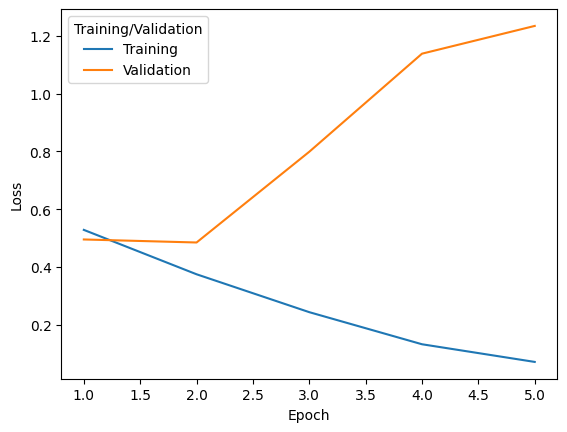

In [12]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
    epoch = int(log_data["epoch"])
    if "loss" in log_data.keys():
        loss = log_data["loss"]
        log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Training"]})
        df = pd.concat([df, log_df], ignore_index=True)
    if "eval_loss" in log_data.keys():
        loss = log_data["eval_loss"]
        log_df = pd.DataFrame({"Epoch": [epoch], "Loss": [loss], "Training/Validation": ["Validation"]})
        df = pd.concat([df, log_df], ignore_index=True)

# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")

In [13]:
#prediction del modello e metriche di valutazione
output_predictions = trainer.predict(test_data)
print(output_predictions)

PredictionOutput(predictions=array([[ 0.18996586, -0.52382207],
       [-0.48753974,  0.01457511],
       [-0.07262029, -0.25698498],
       ...,
       [-2.4993634 ,  1.8744938 ],
       [-2.2638142 ,  1.838354  ],
       [ 2.6894417 , -2.3828921 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.48781558871269226, 'test_f1': 0.7970157217407057, 'test_runtime': 11.0353, 'test_samples_per_second': 123.965, 'test_steps_per_second': 15.496})


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       811
           1       0.71      0.84      0.77       557

    accuracy                           0.80      1368
   macro avg       0.79      0.80      0.79      1368
weighted avg       0.81      0.80      0.80      1368


Confusion Matrix:


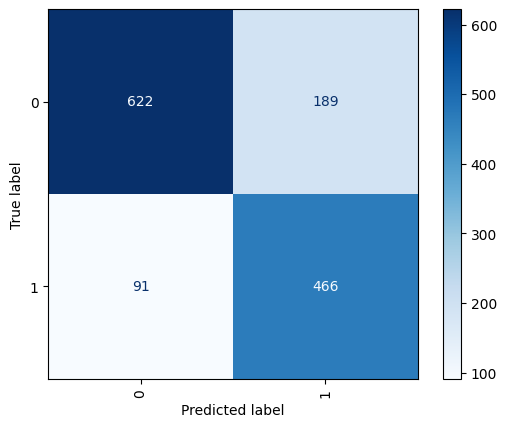

In [14]:
#classification report e confusion matrix
y_test = test_data["label"].tolist()
y_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()

print("Confusion Matrix:")
print(cm)

In [15]:
#carico i due dataset di test

data_folder = "/content/drive/My Drive/profiling_input_tweets/profiling_input_test_1"
documents = os.listdir(data_folder)

all_data_test_1 = []

for document in documents:

    label = document.rstrip('.txt').split('#')[1]
    doc_id = document.rstrip('.txt').split('#')[0]
    data = open('/content/drive/My Drive/profiling_input_tweets/profiling_input_test_1/' + document, 'r')
    text = data.read()

    input_instance = {}
    input_instance["id"] = doc_id
    input_instance["tweet"] = text
    input_instance["label"] = label

    all_data_test_1.append(input_instance)

# Converto da lista di dizionari a dataset
test_data_1 = datasets.Dataset.from_pandas(pd.DataFrame(data=all_data_test_1))

data_folder = "/content/drive/My Drive/profiling_input_tweets/profiling_input_test_2"
documents = os.listdir(data_folder)

all_data_test_2 = []

for document in documents:

    label = document.rstrip('.txt').split('#')[1]

    doc_id = document.rstrip('.txt').split('#')[0]
    data = open('/content/drive/My Drive/profiling_input_tweets/profiling_input_test_2/' + document, 'r')
    text = data.read()

    input_instance = {}
    input_instance["id"] = doc_id
    input_instance["tweet"] = text
    input_instance["label"] = label

    all_data_test_2.append(input_instance)

# Converto da lista di dizionari a dataset
test_data_2 = datasets.Dataset.from_pandas(pd.DataFrame(data=all_data_test_2))

In [16]:
#passo i due test set per lo stesso processing a cui ho fatto passare i dati di training
test_data_1 = test_data_1.map(tokenize, batched=True)
test_data_1.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

test_data_2 = test_data_2.map(tokenize, batched=True)
test_data_2.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1263 [00:00<?, ? examples/s]

In [17]:
#prediction del modello e metriche di valutazione per test set 1
results_test_1 = trainer.predict(test_data_1)
print(results_test_1)

PredictionOutput(predictions=array([[ 1.84046483e+00, -1.97044599e+00],
       [ 1.18830347e+00, -1.50083387e+00],
       [ 1.98526418e+00, -1.95938432e+00],
       [ 2.16591334e+00, -2.02824593e+00],
       [-6.22932792e-01,  1.16054602e-01],
       [ 2.45305228e+00, -2.31501794e+00],
       [-8.77380297e-02, -4.00603294e-01],
       [ 3.55961353e-01, -5.93937695e-01],
       [ 2.54743576e+00, -2.47595954e+00],
       [ 1.48266304e+00, -1.55043578e+00],
       [ 1.52934086e+00, -1.74670374e+00],
       [-1.21432014e-01, -1.79020941e-01],
       [ 1.28208232e+00, -1.44956899e+00],
       [ 1.68476951e+00, -1.54779732e+00],
       [ 3.83984983e-01, -7.04714656e-01],
       [ 1.61551404e+00, -1.47668576e+00],
       [ 6.33828700e-01, -7.77983308e-01],
       [-1.31287992e+00,  9.70779419e-01],
       [ 1.30724549e+00, -1.36438203e+00],
       [ 2.53493571e+00, -2.23281789e+00],
       [ 9.79131401e-01, -1.17460132e+00],
       [-8.06651041e-02, -2.12257117e-01],
       [ 5.42200625e-01, 

In [18]:
#prediction del modello e metriche di valutazione per test set 2
results_test_2 = trainer.predict(test_data_2)
print(results_test_2)

PredictionOutput(predictions=array([[ 0.0481832 , -0.2457803 ],
       [-1.5444146 ,  1.0532725 ],
       [-1.0486941 ,  0.7783297 ],
       ...,
       [-1.7524977 ,  1.2092099 ],
       [ 0.5191527 , -0.620048  ],
       [-0.02807565, -0.22407962]], dtype=float32), label_ids=array([0, 1, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.5215005874633789, 'test_f1': 0.7624692381221648, 'test_runtime': 9.816, 'test_samples_per_second': 128.667, 'test_steps_per_second': 16.096})


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       319
           1       0.82      0.47      0.60       181

    accuracy                           0.77       500
   macro avg       0.79      0.71      0.72       500
weighted avg       0.78      0.77      0.75       500


Confusion Matrix:


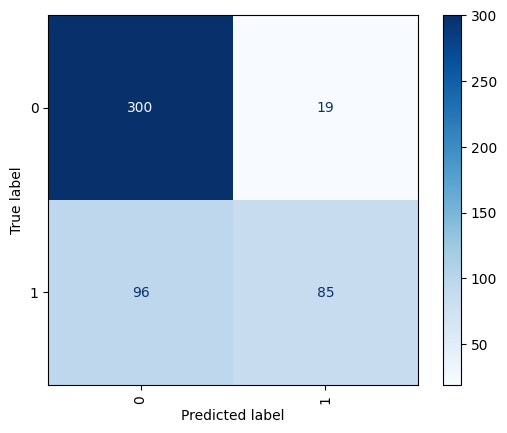

In [19]:
#valutazione sul test set 1
y_test = test_data_1["label"].tolist()
y_pred = np.argmax(results_test_1.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73       641
           1       0.71      0.90      0.79       622

    accuracy                           0.77      1263
   macro avg       0.79      0.77      0.76      1263
weighted avg       0.79      0.77      0.76      1263


Confusion Matrix:


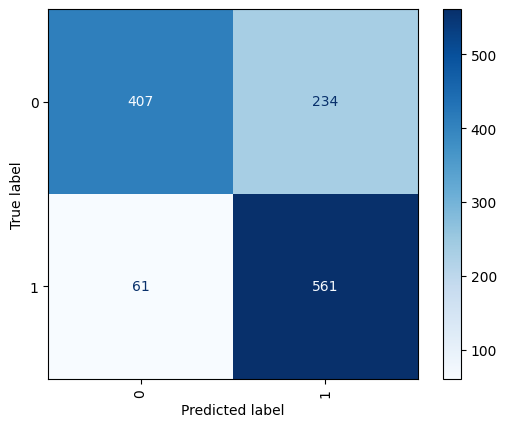

In [20]:
#valutazione sul test set 2
y_test = test_data_2["label"].tolist()
y_pred = np.argmax(results_test_2.predictions, axis=1)

report = classification_report(y_test, y_pred)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues')

print("Classification Report:")
print(report)
print()
print("Confusion Matrix:")
print(cm)